https://docs.ultralytics.com/models/fast-sam/#track-usage

git clone https://github.com/CASIA-IVA-Lab/FastSAM.git

! conda create -n FastSAM python=3.9

! conda activate FastSAM

git clone https://github.com/WiseGeorge/Fast-Facial-Emotion-Monitoring-FFEM-Package.git

In [281]:
from ultralytics.models.fastsam import FastSAMPredictor

small_predictor = FastSAMPredictor(
    overrides=dict(
        conf=0.15,
        task="segment",
        mode="predict",
        model="FastSAM-s.pt",
        save=False,
        imgsz=1024,
    )
)

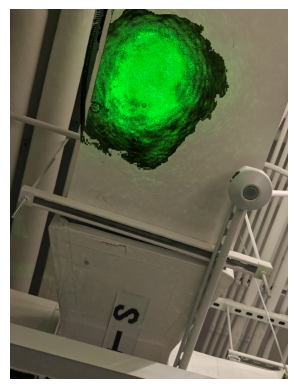

In [282]:
import cv2
import numpy as np

import cv2
import numpy as np


def apply_exponential_contrast(image, gamma=3.0):
    """Apply exponential contrast enhancement"""
    lookup_table = np.array([((i / 255.0) ** gamma) * 255 for i in range(256)]).astype(
        "uint8"
    )
    return cv2.LUT(image, lookup_table)


def apply_high_pass_filter(image):
    """Apply high-pass filter to enhance edges and contrast"""
    # Apply a Gaussian blur to smooth the image (low-pass filter)
    blurred_image = cv2.GaussianBlur(image, (21, 21), 0)
    # Subtract the blurred image from the original image (high-pass filter)
    high_pass = cv2.subtract(image, blurred_image)
    return high_pass


def unsharp_mask(image, sigma=1.0, strength=1.5):
    """Apply unsharp masking to enhance contrast and sharpness"""
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    sharpened = cv2.addWeighted(image, 1 + strength, blurred, -strength, 0)
    return sharpened


def boost_saturation(image, factor=2.0):
    """Boost saturation in the image"""
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv_image[..., 1] = hsv_image[..., 1] * factor  # Increase saturation
    hsv_image[..., 1] = np.clip(hsv_image[..., 1], 0, 255)  # Avoid overflow
    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)


def contrast_stretching(image, low_percentile=1, high_percentile=99):
    """Apply contrast stretching to boost contrast"""
    # Compute low and high percentile intensities
    low, high = np.percentile(image, (low_percentile, high_percentile))
    # Stretch pixel values to the full range
    stretched = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    return np.clip(stretched, low, high)


# Function to enhance the green areas while reducing the contrast of non-green areas
def focus_on_green(image):
    # Convert the image to the HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the range for green color in HSV space (you can adjust this range)
    lower_green = np.array(
        [40, 50, 50]
    )  # Lower bound for green (Hue, Saturation, Value)
    upper_green = np.array(
        [90, 255, 255]
    )  # Upper bound for green (Hue, Saturation, Value)

    # Create a mask to extract the green areas
    green_mask = cv2.inRange(hsv_image, lower_green, upper_green)

    # Invert the mask to select non-green areas
    non_green_mask = cv2.bitwise_not(green_mask)

    # Extract the green areas using the mask
    green_area = cv2.bitwise_and(image, image, mask=green_mask)

    # Step 1: CLAHE for green area contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    green_area_ycrcb = cv2.cvtColor(green_area, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(green_area_ycrcb)
    y_clahe = clahe.apply(y)
    green_area = cv2.merge([y_clahe, cr, cb])
    green_area = cv2.cvtColor(green_area, cv2.COLOR_YCrCb2BGR)

    # Step 2: Apply exponential contrast
    green_area = apply_exponential_contrast(green_area, gamma=3.0)

    # # Step 3: Apply high-pass filter for sharper edges
    # green_area = apply_high_pass_filter(green_area)

    # # Step 4: Apply unsharp masking for additional sharpening
    green_area = unsharp_mask(green_area)

    # # Step 5: Boost the saturation of the green areas
    # green_area = boost_saturation(green_area, factor=3.0)

    # Step 6: Combine with non-green areas (which can be blurred or reduced in contrast)
    non_green_area = cv2.bitwise_and(image, image, mask=non_green_mask)
    # non_green_area = cv2.GaussianBlur(non_green_area, (15, 15), 0)

    # Combine enhanced green areas with non-green areas
    result = cv2.add(green_area, non_green_area)

    return result


# Load the image
image = cv2.imread("test.png")

# Process the image to focus on green
processed_image = focus_on_green(image)

import matplotlib.pyplot as plt

plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
plt.axis("off")  # Hide axes
plt.show()

In [283]:
from PIL import Image
import numpy as np

emotions = {
    "Fear": "00000000",     # Base hash
    "Disgust": "11111111",  # Maximum opposite of "Fear"
    "Angry": "10000000",    # Alternating bits
    "Happy": "01111111",    # Inverse of "Angry"
    "Sad": "01000000",      # Distinct pattern
    "Surprise": "10111111", # Inverse pattern of "Sad"
    "Neutral": "10011001",  # Balanced distribution
}

def average_hash(image, hash_size=8):
    image = image.resize((hash_size, hash_size), Image.Resampling.LANCZOS).convert("L")
    pixels = np.array(image)
    avg = pixels.mean()
    hash_array = pixels > avg
    return ''.join('1' if pixel else '0' for pixel in hash_array.flatten())

def hamming_distance(hash1, hash2):
    return sum(c1 != c2 for c1, c2 in zip(hash1, hash2))

def classify_emotion(image):
    hash = average_hash(image)
    closest_emotion = min(emotions.keys(), key=lambda e: hamming_distance(hash, emotions[e]))
    return closest_emotion

# Example usage
# image = Image.open("test2.png")
# emotion = classify_emotion(image)
# print("Detected Emotion:", emotion)



In [284]:
import cv2


def fancyDraw(img, bbox, color=(255, 117, 44), l=20, t=4, rt=1):
    x, y, w, h = bbox
    x1, y1 = x + w, y + h

    # Drawing Rectangle
    cv2.rectangle(img, bbox, color, rt)
    # Top Left X,Y
    cv2.line(img, (x, y), (x + l, y), color, t)
    cv2.line(img, (x, y), (x, y + l), color, t)
    # Top Right X,Y
    cv2.line(img, (x1, y), (x1 - l, y), color, t)
    cv2.line(img, (x1, y), (x1, y + l), color, t)
    # Buttom Left X,Y
    cv2.line(img, (x, y1), (x + l, y1), color, t)
    cv2.line(img, (x, y1), (x, y1 - l), color, t)
    # Buttom Right X,Y
    cv2.line(img, (x1, y1), (x1 - l, y1), color, t)
    cv2.line(img, (x1, y1), (x1, y1 - l), color, t)

    return img


def draw_text_with_background(img, text, bbox, text_color, bg_color):
    text_offset = 10
    padding = 6
    text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.9, 2)[0]
    text_x = int(bbox[0])
    text_y = int(bbox[1]) - text_offset

    # Calcular las coordenadas del rectángulo
    rect_x1 = text_x - padding
    rect_y1 = text_y - text_size[1] - padding
    rect_x2 = text_x + text_size[0] + padding
    rect_y2 = text_y + padding

    # Dibujar el rectángulo con bordes redondeados
    radius = 10
    cv2.ellipse(
        img,
        (rect_x1 + radius, rect_y1 + radius),
        (radius, radius),
        180,
        0,
        90,
        bg_color,
        -1,
    )
    cv2.ellipse(
        img,
        (rect_x2 - radius, rect_y2 - radius),
        (radius, radius),
        0,
        0,
        90,
        bg_color,
        -1,
    )
    cv2.ellipse(
        img,
        (rect_x1 + radius, rect_y2 - radius),
        (radius, radius),
        90,
        0,
        90,
        bg_color,
        -1,
    )
    cv2.ellipse(
        img,
        (rect_x2 - radius, rect_y1 + radius),
        (radius, radius),
        270,
        0,
        90,
        bg_color,
        -1,
    )
    cv2.rectangle(
        img, (rect_x1, rect_y1 + radius), (rect_x2, rect_y2 - radius), bg_color, -1
    )
    cv2.rectangle(
        img, (rect_x1 + radius, rect_y1), (rect_x2 - radius, rect_y2), bg_color, -1
    )

    # Dibujar el texto encima del rectángulo
    cv2.putText(
        img, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.9, text_color, 2
    )

    return img


def classify_emotion_from_bbox(frame, bbox):
    """
    Classify emotion within a bounding box.

    Args:
        frame (ndarray): The entire frame/image.
        bbox (tuple): Bounding box coordinates (x1, y1, x2, y2).

    Returns:
        str: The closest emotion.
    """
    x1, y1, x2, y2 = bbox
    cropped_img = frame[y1:y2, x1:x2]
    cropped_img_pil = Image.fromarray(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
    return classify_emotion(cropped_img_pil)


def draw_bounding_boxes(
    frame, results, confidence_thresholds=(0.0, 0.3), min_size=5000
):
    for obb in results:
        # Extract coordinates and confidence
        xyxy = obb.xyxy.cpu().numpy()  # Get axis-aligned bounding box [x1, y1, x2, y2]
        conf = obb.conf.cpu().numpy()  # Get confidence scores
        cls = obb.cls.cpu().numpy()  # Get class labels

        for i, box in enumerate(xyxy):
            x1, y1, x2, y2 = box.astype(int)
            confidence = conf[i]
            if (
                confidence < confidence_thresholds[0]
                or confidence > confidence_thresholds[1]
            ):
                # Try and weed out the boxes that are overly confident
                # and underly confident
                continue
            if abs((x2 - x1) * (y2 - y1)) < min_size:
                # weed out boxes that are too small
                continue
            fancyDraw(frame, (x1, y1, x2 - x1, y2 - y1))
            emotion_label = classify_emotion_from_bbox(frame, (x1, y1, x2, y2))
            draw_text_with_background(
                frame,
                emotion_label,
                (x1, y1),
                (255, 255, 255),
                (255, 117, 44),
            )
    return frame

In [285]:
video_capture = cv2.VideoCapture(0)
ret, frame = video_capture.read()

In [286]:
from FFEM import *

# Define la ruta del video
output_path = "output/"
video_path = 0
cap = cv2.VideoCapture(video_path)
pTime = 0
cTime = 0
detector = FaceEmotionDetection()
frame_count = 0

# Define el codec y crea un objeto VideoWriter
fourcc = cv2.VideoWriter_fourcc(*"XVID")
out = cv2.VideoWriter(output_path, fourcc, 20.0, (640, 480))

while True:
    succes, img = cap.read()

    if not succes:
        break

    # Redimensiona la imagen a las dimensiones deseadas
    img = cv2.resize(img, (640, 480))  # Reemplaza con las dimensiones deseadas

    # incrementa el contador de fotogramas
    frame_count += 1

    img = focus_on_green(img)
    segment_everything_results = small_predictor(img)
    img = draw_bounding_boxes(img, segment_everything_results[0].boxes)
    img, bboxes, result, cuadrant = detector.findFaces(img, frame_count, True)

    # Time Management
    cTime = time.time()
    fps = 1 / (cTime - pTime)
    pTime = cTime

    # Escribe el fotograma en el archivo de salida
    out.write(img)

    cv2.imshow("Image", img)

    # verifica si se presionó la tecla 'q'
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
out.release()
cv2.destroyAllWindows()


Ultralytics 8.3.39 🚀 Python-3.9.20 torch-2.2.2 CPU (Intel Core(TM) i7-9750H 2.60GHz)


[ WARN:0@94618.026] global cap.cpp:645 open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.10.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/videoio/src/cap_images.cpp:430: error: (-215:Assertion failed) !filename_pattern.empty() in function 'open'




YOLOv8s-seg summary (fused): 195 layers, 11,779,987 parameters, 0 gradients, 42.4 GFLOPs
0: 768x1024 3 objects, 599.5ms
Speed: 27.3ms preprocess, 599.5ms inference, 9.7ms postprocess per image at shape (1, 3, 768, 1024)

0: 768x1024 2 objects, 574.2ms
Speed: 7.8ms preprocess, 574.2ms inference, 4.4ms postprocess per image at shape (1, 3, 768, 1024)

0: 768x1024 6 objects, 571.8ms
Speed: 10.4ms preprocess, 571.8ms inference, 11.8ms postprocess per image at shape (1, 3, 768, 1024)

0: 768x1024 5 objects, 579.2ms
Speed: 5.7ms preprocess, 579.2ms inference, 9.6ms postprocess per image at shape (1, 3, 768, 1024)

0: 768x1024 5 objects, 555.9ms
Speed: 5.0ms preprocess, 555.9ms inference, 11.4ms postprocess per image at shape (1, 3, 768, 1024)

0: 768x1024 5 objects, 568.9ms
Speed: 6.2ms preprocess, 568.9ms inference, 9.5ms postprocess per image at shape (1, 3, 768, 1024)

0: 768x1024 8 objects, 561.9ms
Speed: 4.6ms preprocess, 561.9ms inference, 15.7ms postprocess per image at shape (1, 3, 7

KeyboardInterrupt: 